In [1]:
from matplotlib import pyplot as plt
from matplotlib import colors

import numpy as np
import random

import time
from IPython.display import clear_output

In [2]:
# agent sorting:
# agent_list.sort(key=lambda agent_this: (agent_this[4], agent_this[0]))

# What it needs to do:
# - Manage cars in and out of rest area
# - Count how many cars in rest area
# - Display in another color for rest area
# - First accident: out of highway
# - Out from accident

In [61]:
# Drowse 40 starts to get drowsy
# Status [1, 2, 3, 4]: 1 is on road, 2 is in ra, 3 is arrived to destionation, 4 is having an accident

direct_ways = [0, 1, 2, 3, 4, 5, 6, 7, 8] # top_right=1, right=2, bot_right=3

# misc. stuff
def grid_0(length, width):
    grid_base = [[0 for _ in range(length)] for _ in range(width)]
    return grid_base

def print_grid(grid):
    for row in reversed(grid):
        print(row)

# these are important
class Grid:
    def __init__(self, length, width):
        self.length = length
        self.width = width
        self.grid = [[0 for _ in range(length)] for _ in range(width)]

    def show_grid(self):
        return self.grid

class Environment:
    def __init__(self, length, width):
        self.grid = [[0 for _ in range(length)] for _ in range(width)]
        self.grid_ra = [[0 for _ in range(length)] for _ in range(width)]

    def add_lane(self, start_x, length_x, pos_y):
        for x in range(0, length_x):
            self.grid[pos_y][x + start_x] = 1

    def add_ra(self, pos_x, pos_y):
        self.grid[pos_y][pos_x] = 2
        self.grid_ra[pos_y][pos_x] = 2

    def show_grid(self):
        return self.grid

    def show_grid_ra(self):
        return self.grid_ra

class Agent:
    def __init__(self, grid_env):
        self.length = len(grid_env[0])
        self.width = len(grid_env)
        self.grid_env = grid_env
        self.grid_agents = [[0 for _ in range(self.length)] for _ in range(self.width)]
        self.agent_ID = 0
        self.list_agents = []
    
    def create(self, pos_x, pos_y, drowse, directions, status):
        agent = [pos_x, pos_y, drowse, directions, status, (self.agent_ID+1)]
        self.list_agents.append(agent)
        self.agent_ID += 1
        return agent

    def size_grid(self):
        return self.length, self.width

    def drowse_random(self):
        return random.randint(10, 30)

    def show_grid(self):
        self.grid_agents = [[0 for _ in range(self.length)] for _ in range(self.width)]
        for agent in range(len(self.list_agents)):
            try: 
                x, y = self.list_agents[agent][0], self.list_agents[agent][1]
                drowse = self.list_agents[agent][2] # depends of how drowsy
                # drowse level
                if drowse < 40:
                    self.grid_agents[y][x] = 1
                elif drowse >= 40 and drowse <= 70:
                    self.grid_agents[y][x] = 2
                elif drowse > 70 and drowse < 10000:
                    self.grid_agents[y][x] = 3
                if drowse >= 10000:
                    self.grid_agents[y][x] = 4
            except: # Kalau mobil udah sampai tujuan
                continue
        return self.grid_agents

    def show_agents(self):
        return self.list_agents # might be useful

    def create_init_random(self, n):
        random.seed(42)
        # All coordinates that satisfy the constraint
        eligible = [
            (r, c)
            for r, row in enumerate(self.grid_env)
            for c, v   in enumerate(row)
            if v == 1
        ]
        #print(eligible)
        if n > len(eligible):
            raise ValueError(
                f"Only {len(eligible)} eligible spots, but you asked for {n} agents."
            )
        for pos_y, pos_x in random.sample(eligible, n):
            #print(pos_y, pos_x)
            agent = Agent.create(self, pos_x, pos_y, 40, 2, 1)
        return self.list_agents
        
    def create_one_random(self):
        random.seed(None)
        # All coordinates that satisfy the constraint
        c = 0 # column or pos_x 0
        eligible = [
            (r, c)
            for r, row in enumerate(self.grid_env)
            if row[c] == 1 and self.grid_agents[r][c] == 0
        ]
        #print(eligible)
        rn_spawn = random.random()
        #print(rn_spawn)
        if rn_spawn >= 0.8 and len(eligible) > 0:
            for pos_y, pos_x in random.sample(eligible, 1):
                #print(pos_y, pos_x)
                agent = Agent.create(self, pos_x, pos_y, Agent.drowse_random(self), 2, 1)
        return self.list_agents

# under construction
class RA_processes:
    def __init__(self, class_agent, class_env):
        self.A = class_agent
        self.E = class_env
        self.grid_size = self.A.size_grid()
        self.RA_list = []
        grid_env = self.E.show_grid()
        for r, row in enumerate(grid_env):
            for c, v in enumerate(row):
                if v == 2:
                    ra_loc = [c, r]
                    self.RA_list.append(ra_loc)

    def resting(self):
        pass

    def status_change(self, agent_this):
        grid_env = self.E.show_grid()
        x, y = agent_this[0], agent_this[1]

        for j in range(len(self.RA_list)):
            RA_this = self.RA_list[j]
            if x == RA_this[0] and y == RA_this[1]:
                agent_this[4] = 2

        if (x+1) < self.grid_size[0]: # still in the grid
            if grid_env[y][x] == 1: # if on the highway
                agent_this[4] = 1
        
    def ra_in(self): # which cars are in rest area
        agent_list = self.A.show_agents()
        ra_agents = [agent_this for agent_this in agent_list if agent_this[4] == 2] # agents in rest area
        return len(ra_agents)

    def rest(self, agent_this):
        if agent_this[2] >= 10:
            agent_this[2] -= 3
        if agent_this[2] < 0:
            agent_this[2] == 0
    
    def ra_out_rn(self, agent_this):
        random.seed(None)
        ra_out = 0
        drowse = agent_this[2]
        rn_out = random.random()
        if drowse < 10 and rn_out >= 0.5:
            ra_out = 1
        return ra_out

class Accident: # anything related to accident (out of highway, collision)
    def __init__(self, class_env, class_agent): # needs environment and agent details, particularly position
        self.A = class_agent
        self.E = class_env
        self.time = 0
        self.accident_record = []

    def check_out(self):
        agent_list = self.A.show_agents()
        grid_env = self.E.show_grid()
        
        for i in range(len(agent_list)):
            
            self.time += 1
            agent_this = agent_list[i]
            pos_x = agent_this[0]
            pos_y = agent_this[1]
            ID = agent_this[-1]

            if agent_this[4] == 4: # we do not need check cars that are confirmed to have an accident
                continue

            else:
                # out from the highway
                if grid_env[pos_y][pos_x] == 0:
                    agent_this[4] = 4
                    new_accident = [self.time, agent_this, 0]
                    self.accident_record.append(new_accident)
        
                # collide with other agent
                for j in range(len(agent_list)):
                    agent_that = agent_list[j]
                    pos_x_that = agent_that[0]
                    pos_y_that = agent_that[0]
                    ID_that = agent_that[-1]
        
                    if (pos_x != pos_x_that and pos_y != pos_y_that):
                        continue
        
                    elif (pos_x == pos_x_that and pos_y == pos_y_that and ID != ID_that):
                        agent_this[4], agent_that[4] = 4, 4
                        new_accident = [self.time, agent_this, agent_that, 0]
                        self.accident_record.append(new_accident)

    def count(self):
        out = 0
        collide = 0
        for i in range(len(self.accident_record)):
            if len(self.accident_record[i]) == 2:
                out += 1
            elif len(self.accident_record[i]) == 3:
                collide += 1
        return out, collide
                    
    def check_collide(self):
        agent_list = self.A.show_agents()
        grid_env = self.E.show_grid()

        for i in range(len(agent_list)):
            agent_this = agent_list[i]
            pos_x = agent_this[0]
            pos_y = agent_this[1]

    def duration(self):
        for i in range(len(self.accident_record)):
            time_here = self.accident_record[i][-1]
            if time_here < 5:
                self.accident_record[i][-1] += 1 # accident creates obstacles

    def show_grid(self):
        grid_size = self.A.size_grid()
        grid_accident = [[0 for _ in range(grid_size[0])] for _ in range(grid_size[1])]

        for i in range(len(self.accident_record)):
            time_here = self.accident_record[i][-1]
            x, y = self.accident_record[i][0][0], self.accident_record[i][0][1]
            if time_here >= 5:
                grid_accident[y][x] = 4
        
class Visualization:
    def __init__(self, grid_env, grid_agents): #requires environment and agent grids
        self.A_grid = grid_agents
        self.E_grid = grid_env

        # separate grid for rest area and accidents will be also here
    
    def plot(self):
        length = len(self.A_grid[0])
        width = len(self.A_grid)
        
        # black = crash, death, whatever
        colormap_E = colors.ListedColormap(["green", "grey", "purple"])
        # [0, 1, 2, 3, 4]
        colormap_A = colors.ListedColormap(["none", "blue", "orange", 
                                            "red", "black"])
        
        plt.figure()
        plt.imshow(self.E_grid, cmap=colormap_E, vmin=0, vmax=2, 
                   aspect='equal', origin='lower')
        plt.imshow(self.A_grid, cmap=colormap_A, vmin=0, vmax=4, 
                   aspect='equal', origin='lower')
        ax = plt.gca()
        
        # Major ticks
        ax.set_xticks(np.arange(0, length, 2))
        ax.set_yticks(np.arange(0, width, 2))
        
        # Minor ticks
        ax.set_xticks(np.arange(-.5, length, 1), minor=True)
        ax.set_yticks(np.arange(-.5, width, 1), minor=True)
        
        # Gridlines based on minor ticks
        ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
        
        # Remove minor ticks
        ax.tick_params(which='minor', bottom=False, left=False)
        
        plt.show()

class Movement:
    def __init__(self, class_agent, class_env):
        self.A = class_agent
        self.E = class_env
        self.RA = RA_processes(self.A, self.E)
        self.grid_size = self.A.size_grid()
        #self.grid_size[0] = length of the grid (x)

    def move_now(self, agent_this):

        grid_env = self.E.show_grid()

        if agent_this[4] != 4: # as long as the agent is not having an accident and on the highway:
            if agent_this[0] < self.grid_size[0] and agent_this[3] == 2:
                agent_this[0] += 1
                agent_this[2] += 1
        
            elif agent_this[0] < self.grid_size[0] and agent_this[3] == 1:
                agent_this[0] += 1
                agent_this[1] += 1 # change y position (left)
                agent_this[2] += 1
        
            elif agent_this[0] < self.grid_size[0] and agent_this[3] == 3:
                agent_this[0] += 1
                agent_this[1] -= 1 # change y position (right)
                agent_this[2] += 1
                
    def move_none(self, agent_this): # stop, agent doesn't move
        pass

    def direction_aware(self, agent_this):
        grid_agents = self.A.show_grid() # for grid update thingy
        #agent_list = self.A.show_agents()
        
        dir_list = [1, 2, 2, 2, 3]
        pos_x = agent_this[0]
        pos_y = agent_this[1]
        ID = agent_this[-1]

        grid_env = self.E.show_grid()

        if (pos_x+1) < self.grid_size[0]: # still in the grid

            if grid_env[pos_y][pos_x] <= 2: # if on the highway or RA

                agent_left = grid_agents[pos_y+1][pos_x+1] # check front left
                agent_front = grid_agents[pos_y][pos_x+1] # check front
                agent_right = grid_agents[pos_y-1][pos_x+1] # check front right
                
                if agent_left == 1 and grid_env[pos_y+1][pos_x+1] == 1: # another agent on the highway
                    dir_list = [x for x in dir_list if x != 1] # no turn left
    
                if agent_right == 1 and grid_env[pos_y-1][pos_x+1] == 1: # another agent on the highway
                    dir_list = [x for x in dir_list if x != 3] # no turn right
    
                if agent_front == 1 and grid_env[pos_y][pos_x+1] == 1: # another agent on the highway
                    dir_list = [x for x in dir_list if x != 2] # no go straight
    
                # rest area on the left, but not drowsy
                if agent_this[2] <= 40 and grid_env[pos_y+1][pos_x+1] == 2:
                    dir_list = [x for x in dir_list if x != 1] # no turn left
                    
                if grid_env[pos_y+1][pos_x+1] == 0: # no road on left
                    dir_list = [x for x in dir_list if x != 1] # no turn left

                if grid_env[pos_y][pos_x+1] == 0: # no road in front of you
                    dir_list = [x for x in dir_list if x != 2] # no go straight
                
                if grid_env[pos_y-1][pos_x+1] == 0: # no road on right
                    dir_list = [x for x in dir_list if x != 3] # no turn right
    
                if len(dir_list) == 0: # no move direction
                    dir_list = [0]
    
                # drowsy driver has all directions available (has a chance to move away from the highway)
                if agent_this[2] >= 70:
                    dir_list = [1, 2, 3]

        # out from the highway (accident)
        elif pos_x < self.grid_size[0] and grid_env[pos_y][pos_x] == 0:
            dir_list = [0]

        # not in the grid
        elif pos_x >= self.grid_size[0]:
            dir_list = [0]

        dir_new = random.choice(dir_list)
            
        agent_this[3] = dir_new
                
    def direction_next(self, agent_this): # used after moving one step
        dir_list = [2]
        pos_x = agent_this[0]
        pos_y = agent_this[1]

        grid_env = self.E.show_grid()

        # normal change direction, 50% chance
        if (pos_x+1) < self.grid_size[0]: # still in the grid
            if grid_env[pos_y][pos_x] == 1: # if on the highway
                if grid_env[pos_y+1][pos_x+1] == 0: # no road on left
                    dir_list = [3, 2, 2, 2, 2]
                        
                if grid_env[pos_y-1][pos_x+1] == 0: # no road on right
                    dir_list = [1, 2, 2, 2, 2]
    
                # rest area check
                if agent_this[2] >= 40 and grid_env[pos_y+1][pos_x+1] == 2: # rest area on left
                    dir_list = [1, 2, 3] # might have a chance to skip ra
        
                # drowsy driver has all directions available (has a chance to move away from the highway)
                if agent_this[2] >= 70:
                    dir_list = [1, 2, 3]

            elif grid_env[pos_y][pos_x] == 2: # if in rest area
                dir_list = [0]

        elif (pos_x) < self.grid_size[0] and grid_env[pos_y][pos_x] == 0:
            dir_list = [0]

        elif pos_x >= self.grid_size[0]:
            dir_list = [0]
            #agent_
    
        dir_new = random.choice(dir_list)
            
        agent_this[3] = dir_new

    def record(self): # record agents
        pass
        
    def move_one(self):
        agent_list = self.A.show_agents()

        # randoming first (helps with randomized pos_y)
        random.shuffle(agent_list)
        # sort by status first [4] (ascending), then pos_x [0] (descending)
        agent_list.sort(key=lambda agent_this: (agent_this[4], -agent_this[0])) # sort on status (where), then pos_x
        
        grid_agents = self.A.show_grid() # for grid update thingy
        grid_env = self.E.show_grid()
        
        #agent_list_new = [] #                                                -> for the next iteration
        for i in range (len(agent_list)):
            agent_this = agent_list[i]
            # If on the highway
            if agent_this[4] == 1: # status: is driving
                Movement.direction_aware(self, agent_this)
                Movement.move_now(self, agent_this)
                #Movement.direction_next(self, agent_this)
            #Accident

            if agent_this[4] == 2:
                if self.RA.ra_out_rn(agent_this) == 1:
                    Movement.direction_aware(self, agent_this)
                    Movement.move_now(self, agent_this)
                else:
                    self.RA.rest(agent_this)

            self.RA.status_change(agent_this)
            
        print("in ra:", self.RA.ra_in())
        
        # After all highway cars on the highway move, cars in rest area move
        # insert command here

In [62]:
# Make grid

length = 20
width = 7

Env = Environment(length, width)
Env.add_ra(15, 4)
Env.add_lane(0, length, 2)
Env.add_lane(0, length, 3)
grid_Env = Env.show_grid()
print_grid(grid_Env)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


in ra: 0


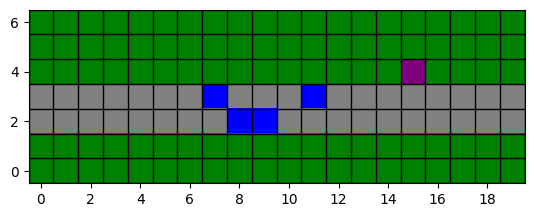

t = 60 15


In [63]:
Cars = Agent(grid_Env)
#Cars.create_init_random(1)
#Cars.create(12, 3, 42, 2, 1) # only for testing
Cars.create(15, 4, 42, 0, 2) # only for testing

zz = Movement(Cars, Env)

Time = 60

for i in range(Time):
    zz.move_one()
    Cars.create_one_random() # chance to add one agent
    Visualization(grid_Env, Cars.show_grid()).plot()
    print("t =", i+1, len(Cars.show_agents()))
    #print(Cars.show_agents())
    # Refresh output
    time.sleep(0.1)
    clear_output(wait=True)